<a href="https://colab.research.google.com/github/ROstapch/MyDBC/blob/main/MyDBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My density baced clustering algorithm

It requires maximum distance between points as only parameter.
On return you get a class with few main values, represented as numpy array


*   **density** - can be used to plot initial density. Can be usefull when evaluating the data before automated clustering, to estimate number of clusters.
*   **cluster_labels** - main value representing cluster labels for each data point after algorithm runs. It has labels for each step of algorithm, which stops when all points are recognized as abnormal and are set to label -1. That means that `cluster_labels[0]` will contain initial clusters, and `cluster_labels[-1]` will have all cluster labels set to -1.
*   **neighbors** - has different data for each step of algorithm, same as cluster_labels. It has indexes of neighbors for each data point. No point in `neighbors[-1]` will have a neighbor.


Main idea of algorithm is so that initial clusters are set based on distance(*distance between points is counted using euclidian metrics, but can be changed if needed*) between points, that is passed in as a parameter. Further reclustering is done after marking points with least deinsity as abnormal. Density threshold value is increased each iteration.




In [251]:
import numpy as np
from scipy.spatial import distance

In [301]:
class MyDBC:

  def __init__(self, radius):
    #distance from point where look up for neighbors 
    self.radius = radius 
    #all data points represented as np array 
    self.data = None 
    #array that contains all cluster labels for each step of algorithm
    self.cluster_labels = None 
    #np array with each point's density
    self.density = None 
    #array that contains all neighbors for each data point for each step of algo
    self.neighbors = None 
    #mask identifying if point has been looked through during clusterization
    self._check_mask = None 

  def density_norm(self):
    return (self.density / self.density.max())
  


  '''
  Getting array of neighbors for each data point in given radius
  Getting density for each data point based on amount of neighbors

  Distance between points is counted using Euclidian metrics
  '''
  def _neighbors_density(self):
    density = []
    #distance between points
    distances = distance.squareform((distance.pdist(self.data, metric='euclidean')))

    neighbors_mask = np.where(distances < self.radius)
    neighbors = np.array([None] * (distances.shape[0]))

    for row, column in zip(neighbors_mask[0], neighbors_mask[1]):
      if (np.any(neighbors[row] == None)):
        neighbors[row] =  np.array([column])
      else:
        neighbors[row] = np.append(neighbors[row], column)

    for row in neighbors:
      density.append(len(row))

    self.density = np.array(density)
    self.neighbors = np.array([neighbors])


  '''
  Check each neighbor of given point to set it's cluster label if it
  wasn't looked through earlier
  
  Function is recursive and exits back to _clusterization if all unchecked 
  neighbors get clusterized
  '''
  def _check_neighbors(self, point_index, current_cluster):
    for neighbor_index in self.neighbors[-1][point_index]:
      if not self._check_mask[neighbor_index]:
        self._check_mask[neighbor_index] = True
        self.cluster_labels[-1][neighbor_index] = current_cluster
        MyDBC._check_neighbors(self, neighbor_index, current_cluster)

  '''
  Main part of clusterization, work with _check_neighbors

  Iterates through all data points and changes cluster label
  that is being set to a point and it's neighbors

  When runs out of unchecked neighbors changes cluster_label
  '''
  def _clusterization(self):
    self._check_mask = np.zeros_like(self.density, dtype=bool)
    current_cluster = 0
    for point_index in range(len(self.data)):
      if not self._check_mask[point_index]:
        self._check_mask[point_index] = True
        if (len(self.neighbors[-1][point_index]) > 1):
          self.cluster_labels[-1][point_index] = current_cluster
          MyDBC._check_neighbors(self, point_index, current_cluster)
          current_cluster += 1
        else:
          self.cluster_labels[-1][point_index] = -1

  '''
  Removes points from their neighbors each iteration as threshold value of
  density is inctreased, sets the cluster for this points as -1
  '''
  def _remove_neighbors(self, point_index):
    neighbors_indexes = self.neighbors[-1][point_index].copy()
    for neighbor_index in neighbors_indexes:
      self.neighbors[-1][neighbor_index] = \
        self.neighbors[-1][neighbor_index][self.neighbors[-1][neighbor_index] != point_index]
    self.neighbors[-1][point_index] = np.array([])


  '''
  Cuts away point that are beyond threshold value of density
  On each cut runs reclustering, cut away points' cluster label is set to -1

  New cluster labels and neighbors are saved as last array element in existing
  self.cluster_labels and self.neighbors arrays
  '''
  def dbc(self):
    cluster_mask = (self.cluster_labels[-1] != -1)
    cluster_count = len( set(self.cluster_labels[-1]) )
    threshold_dens = (self.density[cluster_mask]).min()
    
    while (not self.cluster_labels[-1].all(-1)):
      cluster_mask = (self.cluster_labels[-1] != -1)
      if (not cluster_mask.any()):
        break
      threshold_dens += 1

      new_dens = []
      for point in self.neighbors[-1]:
        new_dens.append(len(point))
      new_dens = np.array(new_dens)
      cut_points = np.where(new_dens < threshold_dens)[0]

      self.neighbors = np.append(self.neighbors, [self.neighbors[-1]], axis = 0)
      for point in cut_points:
        MyDBC._remove_neighbors(self, point)

      self.cluster_labels = np.append(self.cluster_labels, [self.cluster_labels[-1]], axis = 0)
      self.cluster_labels[-1].fill(-1)
      MyDBC._clusterization(self)

  '''
  Main function of MyDBC

  Gets data on input
  '''
  def fit(self, data):
    self.data = np.array(data)
    
    MyDBC._neighbors_density(self)
    
    temp = np.array(self.density, dtype=int)
    temp.fill(-1)
    self.cluster_labels = np.array([temp])

    MyDBC._clusterization(self)
    MyDBC.dbc(self)



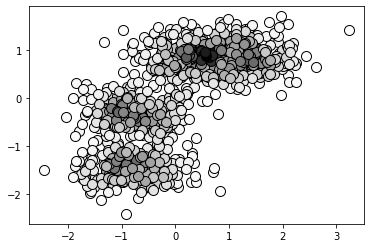

In [280]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


centers = [[0, 1], [1, 1], [-1, -1], [-1, -3]]
X, labels_true = (n_samples=1000, centers=centers, cluster_std=0.5, random_state=np.random.randint(0, 100))
X = StandardScaler().fit_transform(X)

dbc = MyDBC(0.2)
dbc.fit(X)

dens = dbc.density_norm()

colors = plt.cm.Greys(dens)
for point, col, in zip(X, colors):
  plt.plot(point[0], point[1], 'o', color = col, markeredgecolor='k', markersize=10)
plt.show()

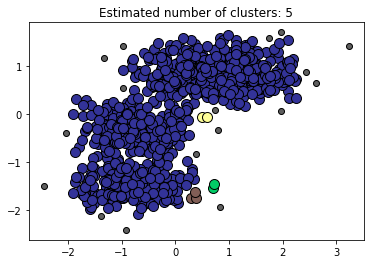

cluster № 0 - 976
cluster № 1 - 2
cluster № 2 - 2
cluster № 3 - 3
cluster № -1 - 17


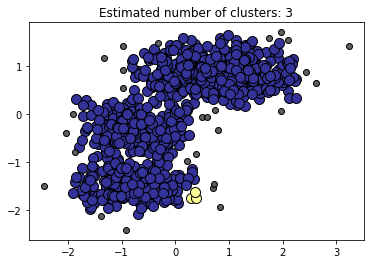

cluster № 0 - 970
cluster № 1 - 3
cluster № -1 - 27


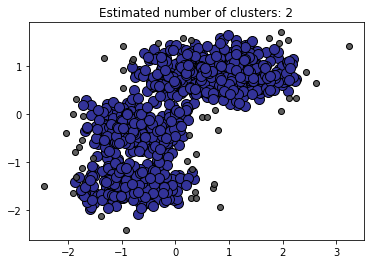

cluster № 0 - 953
cluster № -1 - 47


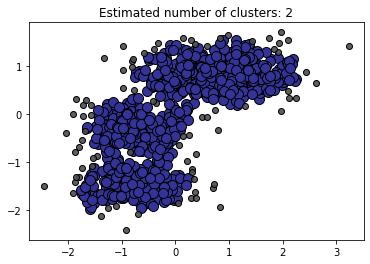

cluster № 0 - 920
cluster № -1 - 80


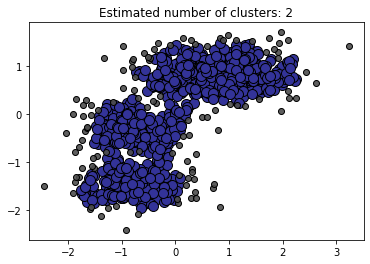

cluster № 0 - 890
cluster № -1 - 110


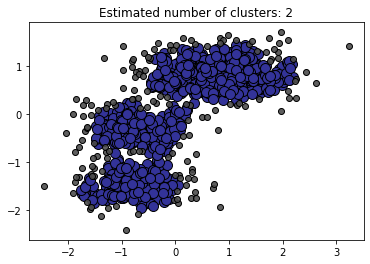

cluster № 0 - 846
cluster № -1 - 154


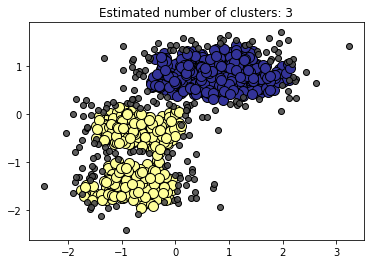

cluster № 0 - 416
cluster № 1 - 392
cluster № -1 - 192


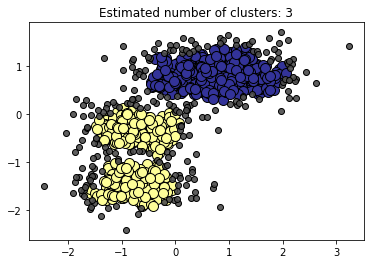

cluster № 0 - 401
cluster № 1 - 369
cluster № -1 - 230


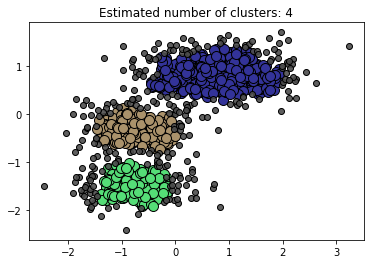

cluster № 0 - 390
cluster № 1 - 167
cluster № 2 - 178
cluster № -1 - 265


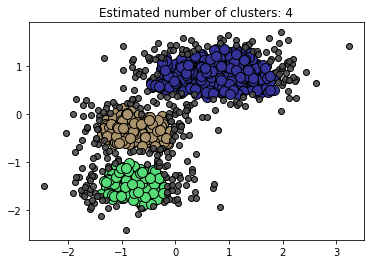

cluster № 0 - 381
cluster № 1 - 157
cluster № 2 - 163
cluster № -1 - 299


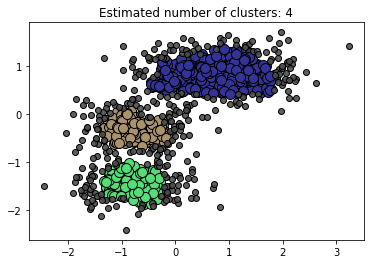

cluster № 0 - 369
cluster № 1 - 146
cluster № 2 - 149
cluster № -1 - 336


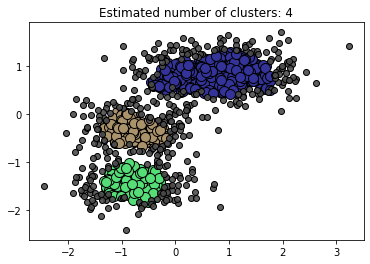

cluster № 0 - 340
cluster № 1 - 136
cluster № 2 - 140
cluster № -1 - 384


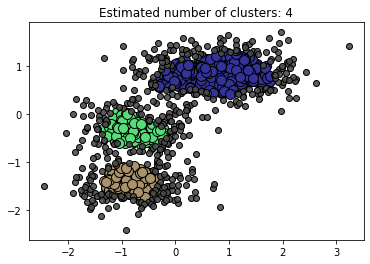

cluster № 0 - 312
cluster № 1 - 126
cluster № 2 - 116
cluster № -1 - 446


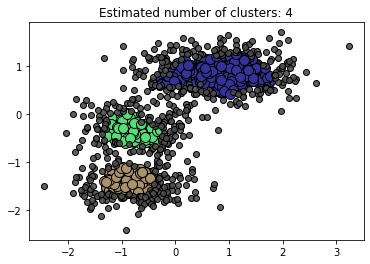

cluster № 0 - 278
cluster № 1 - 110
cluster № 2 - 103
cluster № -1 - 509


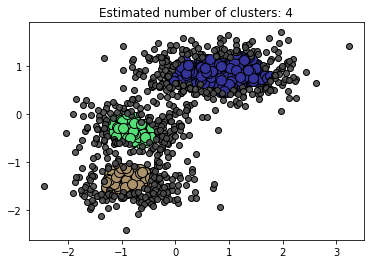

cluster № 0 - 245
cluster № 1 - 94
cluster № 2 - 91
cluster № -1 - 570


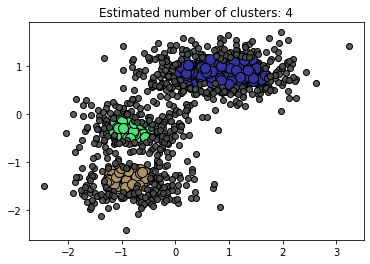

cluster № 0 - 217
cluster № 1 - 75
cluster № 2 - 80
cluster № -1 - 628


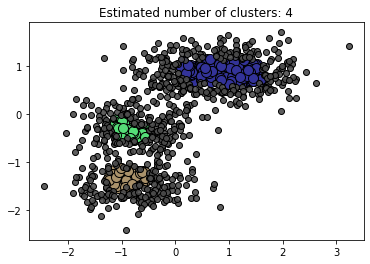

cluster № 0 - 198
cluster № 1 - 57
cluster № 2 - 69
cluster № -1 - 676


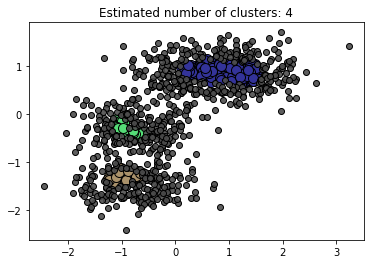

cluster № 0 - 179
cluster № 1 - 40
cluster № 2 - 44
cluster № -1 - 737


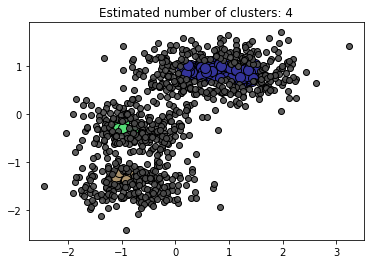

cluster № 0 - 162
cluster № 1 - 19
cluster № 2 - 19
cluster № -1 - 800


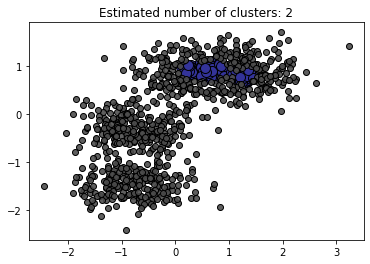

cluster № 0 - 143
cluster № -1 - 857


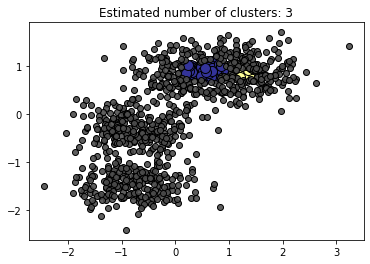

cluster № 0 - 95
cluster № 1 - 15
cluster № -1 - 890


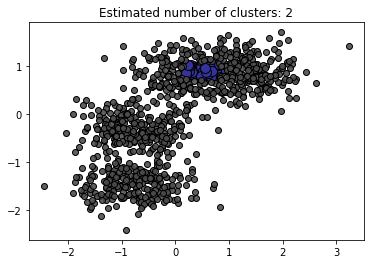

cluster № 0 - 86
cluster № -1 - 914


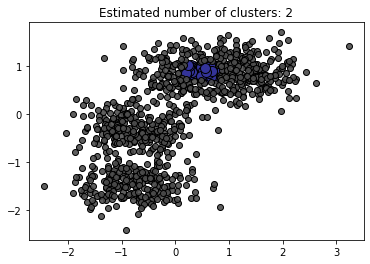

cluster № 0 - 81
cluster № -1 - 919


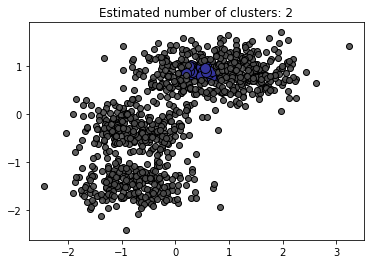

cluster № 0 - 72
cluster № -1 - 928


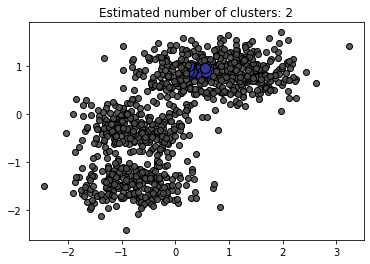

cluster № 0 - 60
cluster № -1 - 940


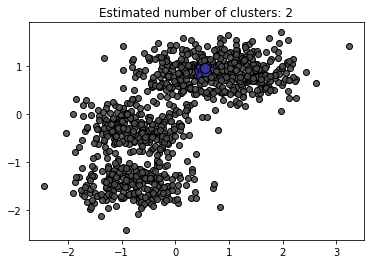

cluster № 0 - 43
cluster № -1 - 957


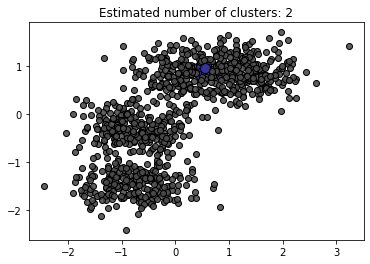

cluster № 0 - 33
cluster № -1 - 967


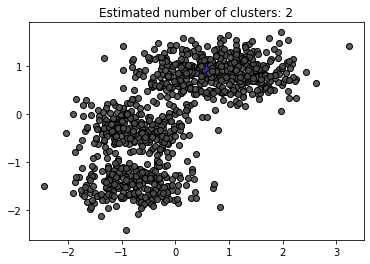

cluster № 0 - 20
cluster № -1 - 980


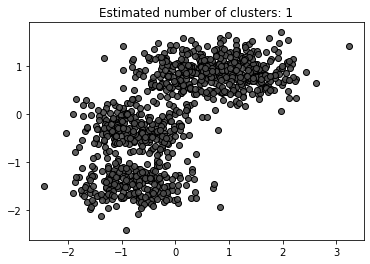

cluster № -1 - 1000


In [281]:
for step in dbc.cluster_labels:
  unique_labels = set(step)
  colors = [plt.cm.terrain(each)
            for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      markersize=10
      if k == -1:
          # Black used for noise.
          markersize=6
          col = [0.3, 0.3, 0.3, 0.9]

      class_member_mask = (step == k)
      xy = X[class_member_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=markersize)
  plt.title('Estimated number of clusters: %d' % len(unique_labels))
  plt.show()

  for lb in unique_labels:
    print("cluster № %d - %d" %(lb, np.count_nonzero(step == lb)))

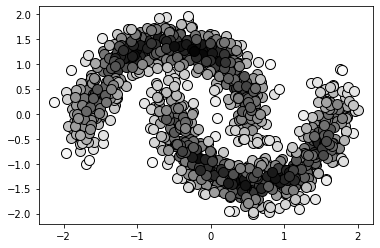

In [298]:
X, labels_true = make_moons(n_samples=1000, noise=0.15)
X = StandardScaler().fit_transform(X)

dbc = MyDBC(0.3)
dbc.fit(X)

dens = dbc.density_norm()

colors = plt.cm.Greys(dens)
for point, col, in zip(X, colors):
  plt.plot(point[0], point[1], 'o', color = col, markeredgecolor='k', markersize=10)
plt.show()

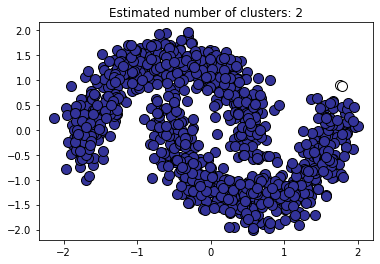

cluster № 0 - 998
cluster № 1 - 2


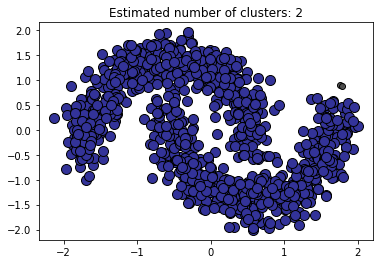

cluster № 0 - 998
cluster № -1 - 2


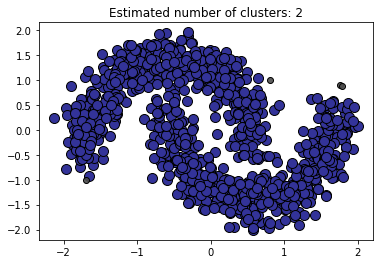

cluster № 0 - 996
cluster № -1 - 4


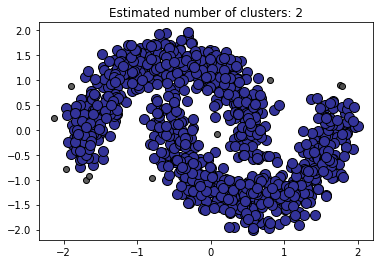

cluster № 0 - 990
cluster № -1 - 10


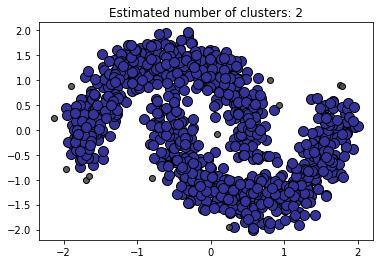

cluster № 0 - 988
cluster № -1 - 12


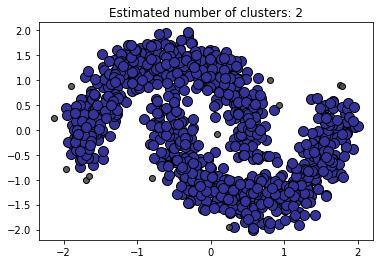

cluster № 0 - 988
cluster № -1 - 12


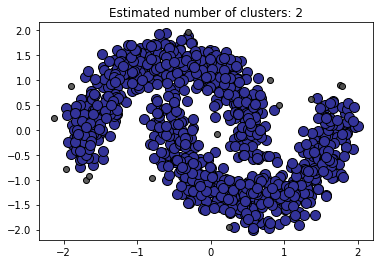

cluster № 0 - 986
cluster № -1 - 14


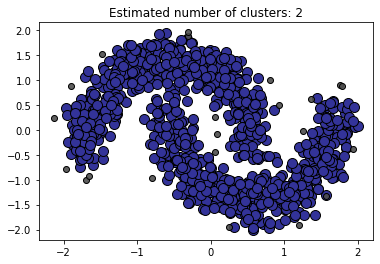

cluster № 0 - 978
cluster № -1 - 22


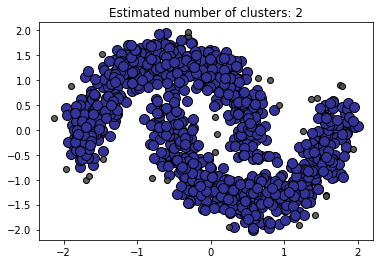

cluster № 0 - 972
cluster № -1 - 28


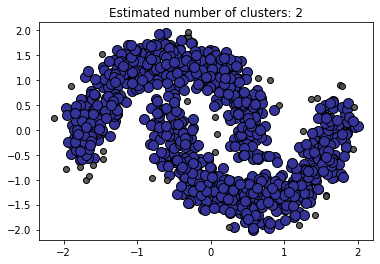

cluster № 0 - 967
cluster № -1 - 33


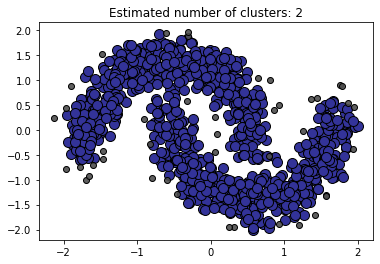

cluster № 0 - 957
cluster № -1 - 43


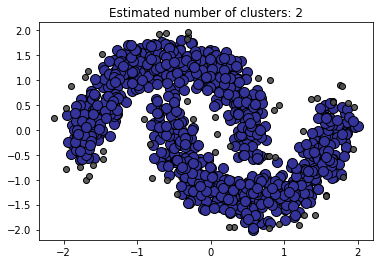

cluster № 0 - 944
cluster № -1 - 56


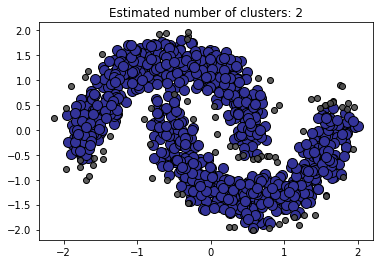

cluster № 0 - 918
cluster № -1 - 82


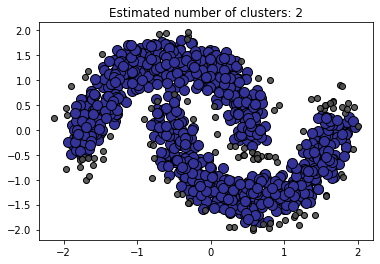

cluster № 0 - 892
cluster № -1 - 108


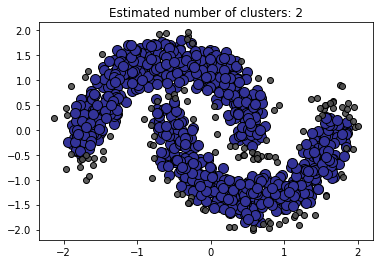

cluster № 0 - 874
cluster № -1 - 126


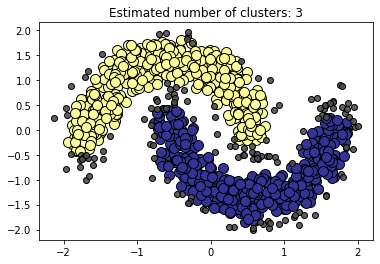

cluster № 0 - 418
cluster № 1 - 439
cluster № -1 - 143


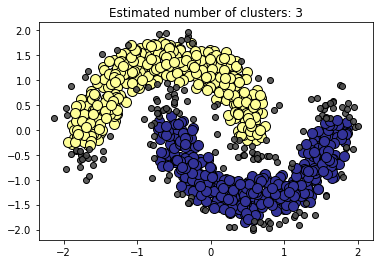

cluster № 0 - 403
cluster № 1 - 426
cluster № -1 - 171


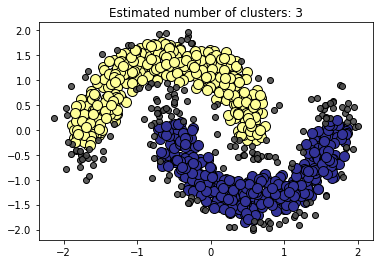

cluster № 0 - 393
cluster № 1 - 417
cluster № -1 - 190


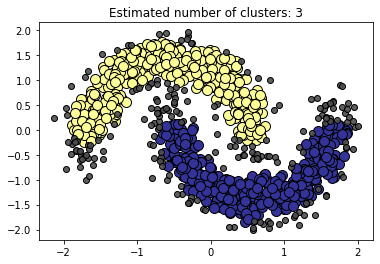

cluster № 0 - 380
cluster № 1 - 407
cluster № -1 - 213


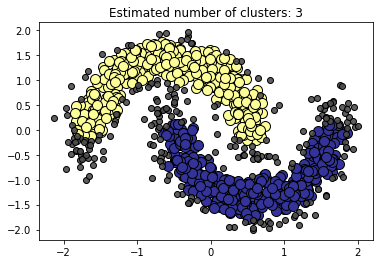

cluster № 0 - 365
cluster № 1 - 391
cluster № -1 - 244


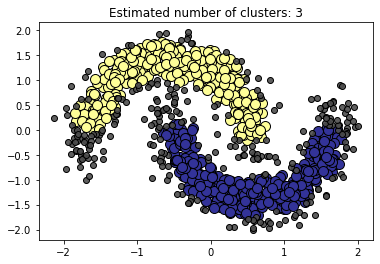

cluster № 0 - 346
cluster № 1 - 370
cluster № -1 - 284


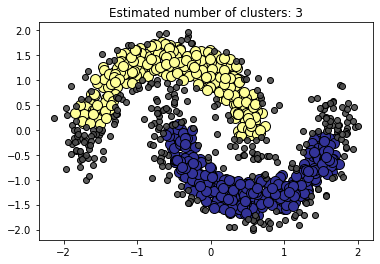

cluster № 0 - 330
cluster № 1 - 350
cluster № -1 - 320


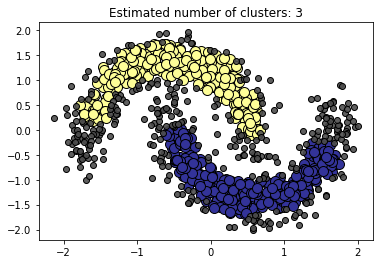

cluster № 0 - 309
cluster № 1 - 327
cluster № -1 - 364


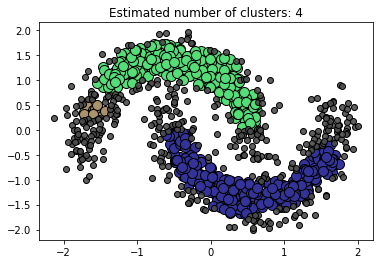

cluster № 0 - 290
cluster № 1 - 280
cluster № 2 - 17
cluster № -1 - 413


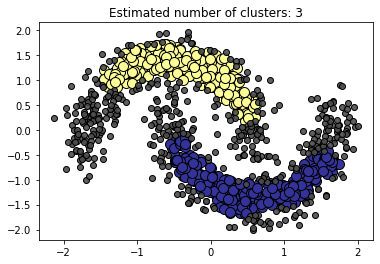

cluster № 0 - 268
cluster № 1 - 256
cluster № -1 - 476


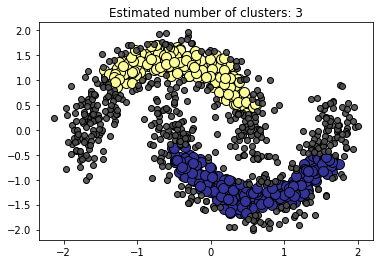

cluster № 0 - 244
cluster № 1 - 225
cluster № -1 - 531


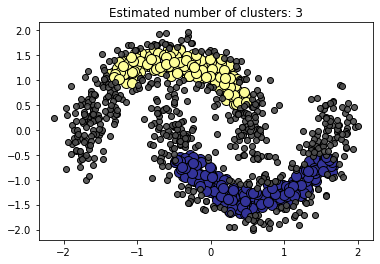

cluster № 0 - 223
cluster № 1 - 195
cluster № -1 - 582


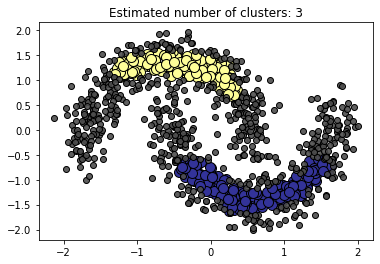

cluster № 0 - 188
cluster № 1 - 159
cluster № -1 - 653


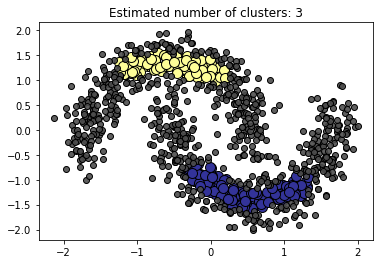

cluster № 0 - 143
cluster № 1 - 121
cluster № -1 - 736


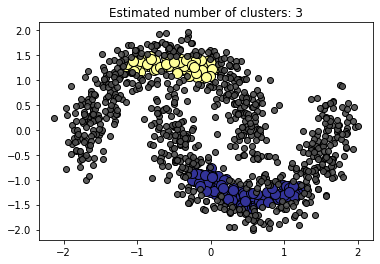

cluster № 0 - 115
cluster № 1 - 84
cluster № -1 - 801


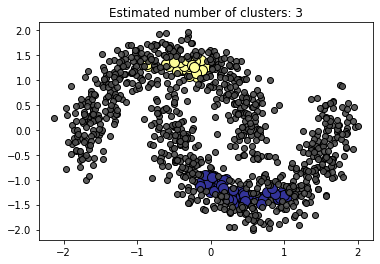

cluster № 0 - 68
cluster № 1 - 37
cluster № -1 - 895


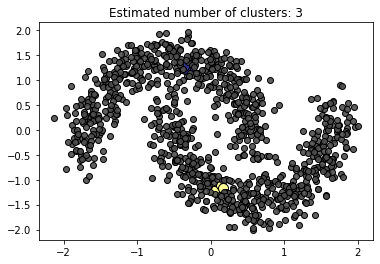

cluster № 0 - 3
cluster № 1 - 4
cluster № -1 - 993


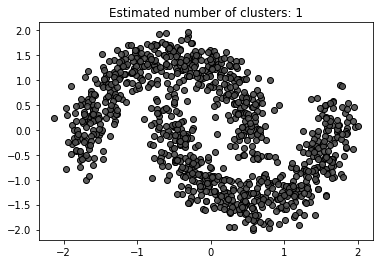

cluster № -1 - 1000


In [299]:
for step in dbc.cluster_labels:
  unique_labels = set(step)
  colors = [plt.cm.terrain(each)
            for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      markersize=10
      if k == -1:
          # Black used for noise.
          markersize=6
          col = [0.3, 0.3, 0.3, 0.9]

      class_member_mask = (step == k)
      xy = X[class_member_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=markersize)
  plt.title('Estimated number of clusters: %d' % len(unique_labels))
  plt.show()

  for lb in unique_labels:
    print("cluster № %d - %d" %(lb, np.count_nonzero(step == lb)))